In [8]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import torch
import pandas as pd
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
from scipy.signal import argrelextrema
from scipy.stats import gaussian_kde

In [ ]:
#1~3
# --- 1. SAMと可視化のための関数 ---

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

def process_with_sam(image_path, model_checkpoint):
    print("--- SAM解析開始 ---")
    image = cv2.imread(image_path)
    if image is None:
        print(f"エラー: 画像が見つかりません: {image_path}")
        return None
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"使用デバイス: {device}")
    
    # ★軽量化のため 'vit_b' を推奨しますが、'vit_h' のままであれば以下を使用
    model_type = "vit_b"  
    
    if not os.path.exists(model_checkpoint):
        print(f"エラー: モデルファイル {model_checkpoint} が見つかりません。")
        return None

    print("モデルをロード中...")
    sam = sam_model_registry[model_type](checkpoint=model_checkpoint)
    sam.to(device=device)

    mask_generator = SamAutomaticMaskGenerator(
        model=sam,
        points_per_side=32,
        pred_iou_thresh=0.86,
        stability_score_thresh=0.92,
        crop_n_layers=0,
        crop_n_points_downscale_factor=1,
        min_mask_region_area=100,
    )

    print("セグメンテーション実行中...")
    masks = mask_generator.generate(image)
    print(f"検出された石（領域）の数: {len(masks)}")
    return masks

def sort_masks_bottom_up(masks):
    # bbox[1] (y座標) が大きい順 ＝ 画像の下にある順
    return sorted(masks, key=lambda x: x['bbox'][1], reverse=True)

def visualize_labeled_masks(image, masks, title="Labeled Stones"):
    vis_img = image.copy()
    overlay = vis_img.copy()
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    for i, mask in enumerate(masks):
        idx = i + 1
        y_indices, x_indices = np.where(mask['segmentation'])
        if len(y_indices) == 0: continue
        center_y = int(np.mean(y_indices))
        center_x = int(np.mean(x_indices))
        
        color = np.random.randint(0, 255, (3,)).tolist()
        overlay[mask['segmentation']] = color
        
        text = str(idx)
        cv2.putText(vis_img, text, (center_x-10, center_y+10), font, 0.6, (255, 255, 255), 2)

    cv2.addWeighted(overlay, 0.4, vis_img, 0.6, 0, vis_img)
    plt.figure(figsize=(10, 10))
    plt.imshow(vis_img)
    plt.title(title)
    plt.axis('off')
    plt.show()

# --- 2. メイン処理関数（ここを修正：データをreturnするように変更） ---

def main():
    image_path = "images/pyramid2_test.jpeg"
    checkpoint_path = "sam_vit_b_01ec64.pth" # 適切なパスに変更してください

    # 2-1. SAM実行
    masks = process_with_sam(image_path, checkpoint_path)
    if masks is None:
        return None, None

    # 画像再読み込み（可視化用）
    image_bgr = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # 2-2. 対話的修正ループ
    current_masks = sort_masks_bottom_up(masks)
    
    while True:
        visualize_labeled_masks(image_rgb, current_masks, title=f"Check: {len(current_masks)} stones")
        print("【修正モード】削除したい石の番号をスペース区切りで入力（例: '3 5'）。完了ならEnter。")
        user_input = input("削除番号 >> ")
        
        if not user_input.strip():
            break
        
        try:
            remove_ids = set(map(int, user_input.split()))
            new_masks = [m for i, m in enumerate(current_masks) if (i + 1) not in remove_ids]
            current_masks = new_masks
            if len(current_masks) == 0: break
        except ValueError:
            print("数値を入力してください。")

    # 2-3. データフレームの作成（これが抜けていたため追加）
    print("データフレームを作成中...")
    data_list = []
    for i, m in enumerate(current_masks):
        data_list.append({
            'Stone_ID': i + 1,
            'Area': m['area'],
            'bbox': m['bbox'] # 後の処理で使うため保存
        })
    df = pd.DataFrame(data_list)

    print("メイン処理完了。データを返却します。")
    # ★重要: ここで変数を外に返す
    return current_masks, df


# --- 3. 分析ロジック（段の推定） ---

def add_centroid_and_group_tiers(masks, df_stones):
    # 重心の計算と追加
    centroids_y = []
    centroids_x = []
    for m in masks:
        x, y, w, h = m['bbox']
        centroids_y.append(y + h / 2)
        centroids_x.append(x + w / 2)
    
    df_stones['Centroid_X'] = centroids_x
    df_stones['Centroid_Y'] = centroids_y

    # 段（Tier）の推定
    y_values = df_stones['Centroid_Y'].values
    kde = gaussian_kde(y_values, bw_method=0.1)
    y_grid = np.linspace(min(y_values)-10, max(y_values)+10, 500)
    y_density = kde(y_grid)
    
    valleys_indices = argrelextrema(y_density, np.less, order=10)[0]
    boundaries = sorted([-np.inf] + list(y_grid[valleys_indices]) + [np.inf])
    
    # ラベリング
    df_stones['Tier_Group'] = pd.cut(df_stones['Centroid_Y'], bins=boundaries, labels=False)
    unique_tiers = sorted(df_stones['Tier_Group'].unique(), reverse=True)
    tier_map = {original: i+1 for i, original in enumerate(unique_tiers)}
    df_stones['Tier'] = df_stones['Tier_Group'].map(tier_map)
    df_stones.drop(columns=['Tier_Group'], inplace=True)
    
    return df_stones, y_grid, y_density, boundaries


--- SAM解析開始 ---
使用デバイス: cpu
モデルをロード中...
セグメンテーション実行中...
検出された石（領域）の数: 81


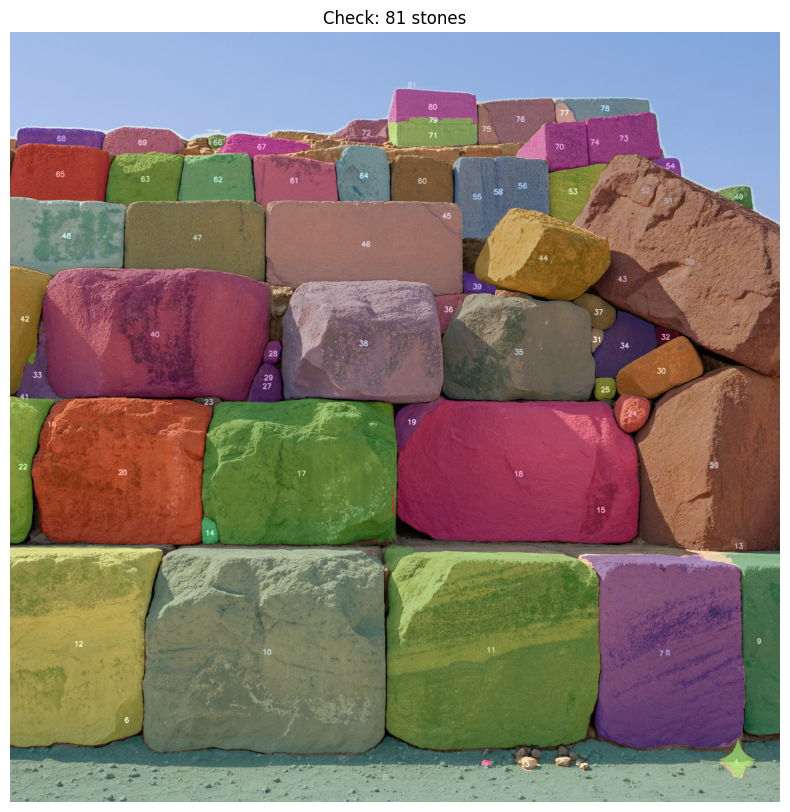

【修正モード】削除したい石の番号をスペース区切りで入力（例: '3 5'）。完了ならEnter。


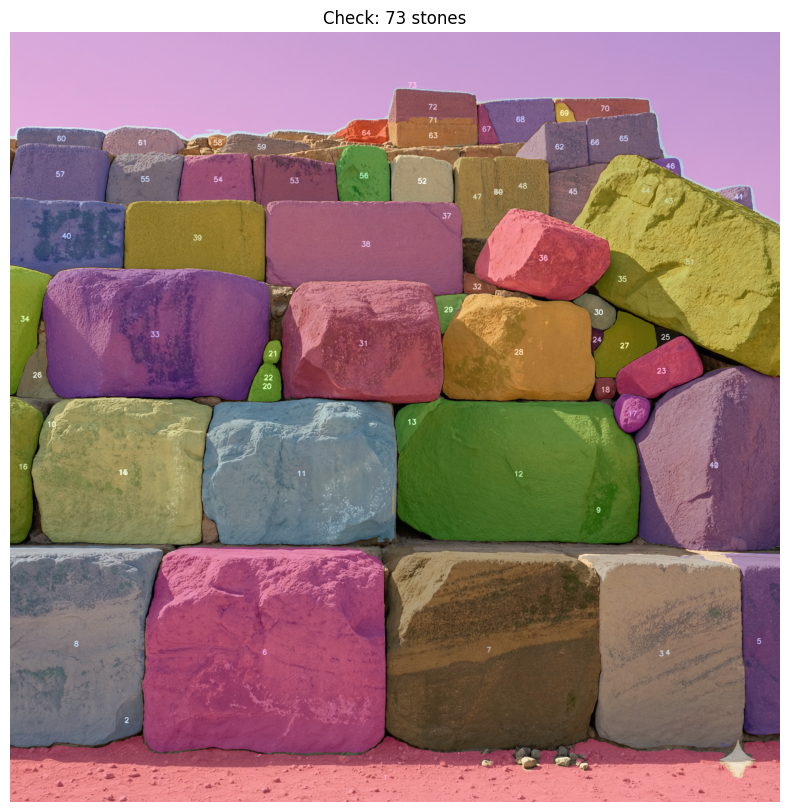

【修正モード】削除したい石の番号をスペース区切りで入力（例: '3 5'）。完了ならEnter。


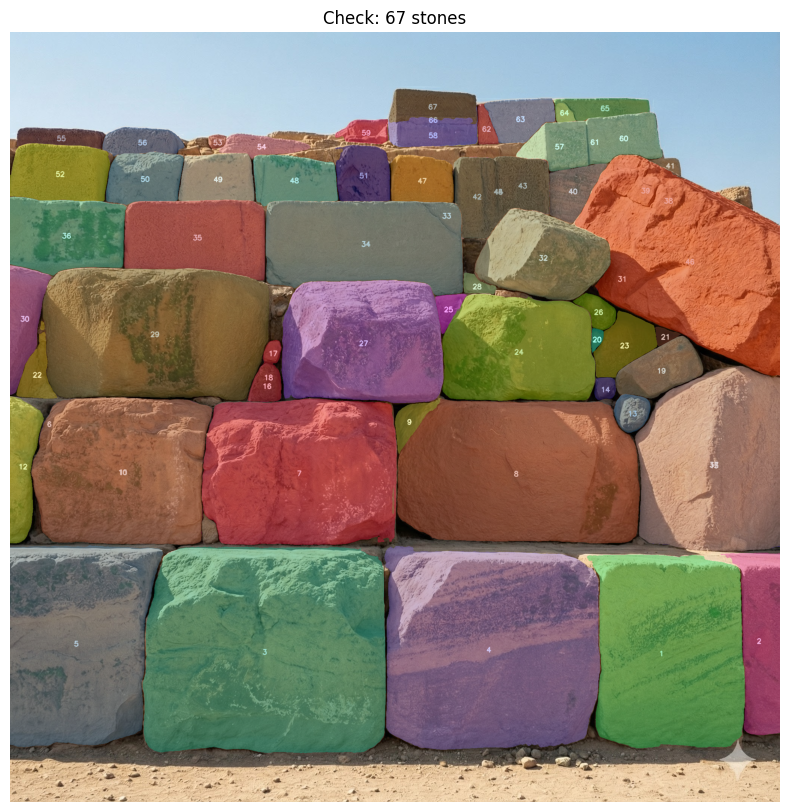

【修正モード】削除したい石の番号をスペース区切りで入力（例: '3 5'）。完了ならEnter。


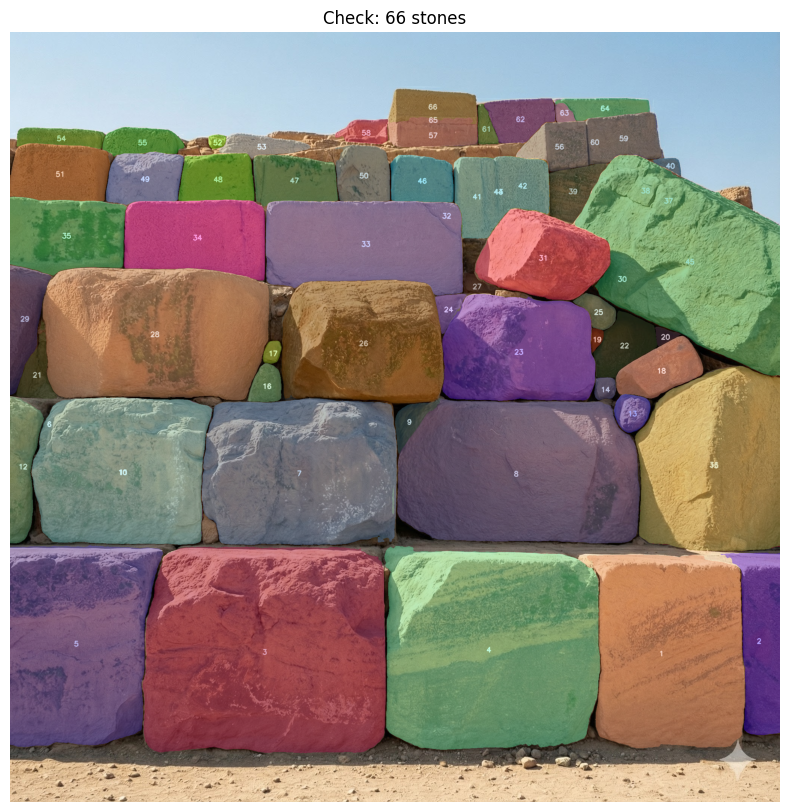

【修正モード】削除したい石の番号をスペース区切りで入力（例: '3 5'）。完了ならEnter。
データフレームを作成中...
メイン処理完了。データを返却します。
垂直方向のグルーピングを開始します...


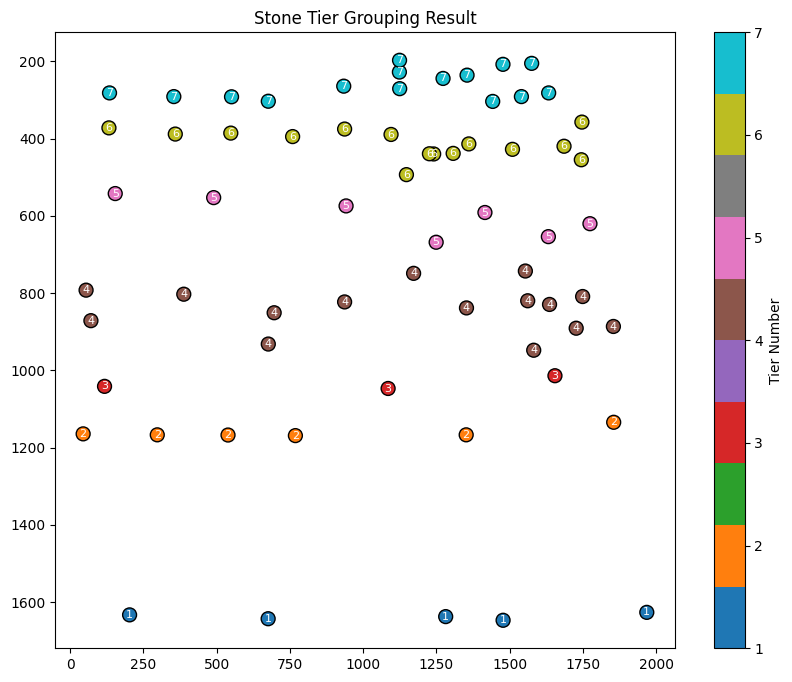

--- 各段の石の数 ---
Tier
1     5
2     6
3     3
4    15
5     7
6    15
7    15
Name: count, dtype: int64


In [13]:
# --- 4. 実行ブロック（ここが重要） ---

if __name__ == "__main__":
    # ★ main() の戻り値をグローバル変数として受け取る
    current_masks, df = main()

    # データが正常に取得できた場合のみ分析へ進む
    if current_masks is not None and df is not None:
        print("垂直方向のグルーピングを開始します...")
        
        df, y_grid, density, boundaries = add_centroid_and_group_tiers(current_masks, df)
        
        # 可視化
        plt.figure(figsize=(10, 8))
        plt.gca().invert_yaxis()
        scatter = plt.scatter(df['Centroid_X'], df['Centroid_Y'], c=df['Tier'], cmap='tab10', s=100, edgecolors='k')
        plt.colorbar(scatter, label='Tier Number')
        
        for idx, row in df.iterrows():
            plt.text(row['Centroid_X'], row['Centroid_Y'], str(int(row['Tier'])), color='white', ha='center', va='center', fontsize=8)
            
        plt.title("Stone Tier Grouping Result")
        plt.show()
        
        print("--- 各段の石の数 ---")
        print(df['Tier'].value_counts().sort_index())
    else:
        print("処理が中断されました。")
        

In [ ]:
#5ここからは水平方向のグラフ化フェーズ